# MNIST

- AstroDave, Will Cukierski. (2012). Digit Recognizer. Kaggle. https://kaggle.com/competitions/digit-recognizer

## Load Data

In [43]:
import numpy as np
import pandas as pd

In [44]:
train_df = pd.read_csv("./data/mnist/train.csv")
test_df = pd.read_csv("./data/mnist/test.csv")

In [45]:
display(train_df.head(2))
display(test_df.head(2))

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
def get_X_y(df: pd.DataFrame, 
            train: bool,
            frac: float = None,
            random_state: int = None):
    
    if train:
        sample_df = df.groupby("label").sample(frac=frac, random_state=random_state)
        X, y = sample_df.iloc[:, 1:].values, sample_df.iloc[:, 0].values
    else:
        X = df.values
        y = None
    
    X = X.reshape(-1, 28, 28).astype(np.uint8)
    return np.moveaxis(np.stack((X,) * 3, axis=1), source=1, destination=-1), y

In [47]:
train_X, train_y = get_X_y(train_df, train=True, frac=0.05, random_state=0)
test_X, _ = get_X_y(test_df, train=False)

In [48]:
import os

train_dir = "./data/mnist/train"
test_dir = "./data/mnist/test"

if not os.path.exists(train_dir):
    os.mkdir(train_dir)
if not os.path.exists(test_dir):
    os.mkdir(test_dir)
    
for label in np.unique(train_y):
    if not os.path.exists(f"{train_dir}/{label}"):
        os.mkdir(f"{train_dir}/{label}")

In [49]:
from PIL import Image

for i in range(train_X.shape[0]): 
    Image.fromarray(train_X[i]).save(f"{train_dir}/{train_y[i]}/{i}.jpg")
    
for i in range(test_X.shape[0]):
    Image.fromarray(test_X[i]).save(f"{test_dir}/{i}.jpg")

## Train Model

In [50]:
from fastai.vision.all import *

In [51]:
dls = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items = get_image_files,
                get_y = parent_label,
                splitter = RandomSplitter()
               ).dataloaders(train_dir)

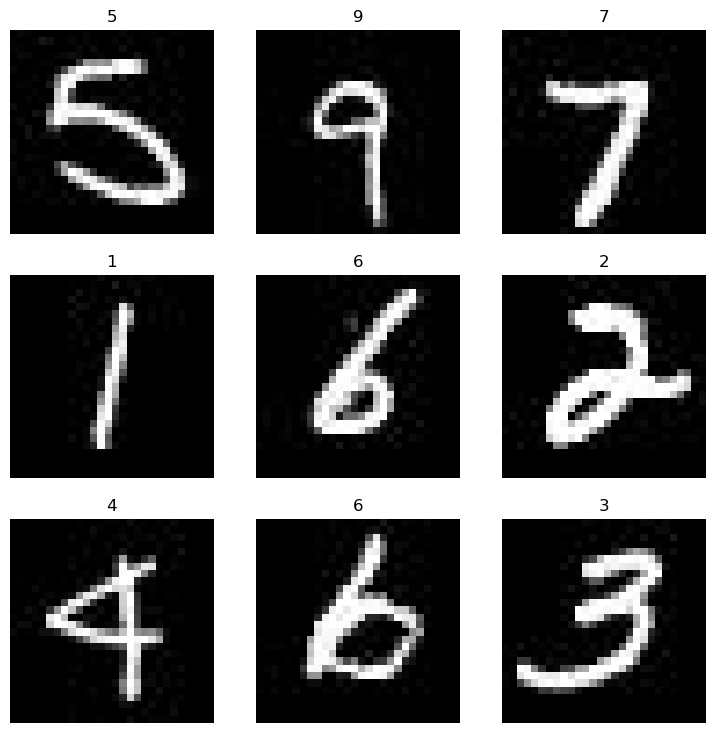

In [52]:
dls.show_batch()

In [53]:
dls.n

1681

In [54]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.928154,1.347422,0.430952,00:07


epoch,train_loss,valid_loss,error_rate,time
0,1.481526,0.993762,0.323810,00:08
1,1.170102,0.677061,0.190476,00:08
2,0.850052,0.567972,0.152381,00:07
3,0.593134,0.495614,0.114286,00:08
4,0.411312,0.470167,0.102381,00:08
5,0.285538,0.404801,0.100000,00:08
6,0.206531,0.390356,0.102381,00:08
7,0.147591,0.366526,0.090476,00:08
8,0.108263,0.369601,0.092857,00:07
9,0.083111,0.380087,0.107143,00:08


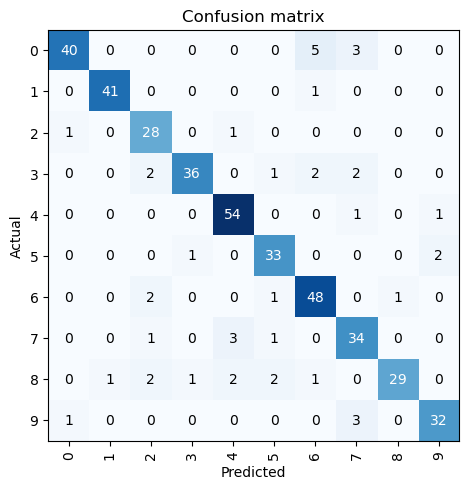

In [55]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

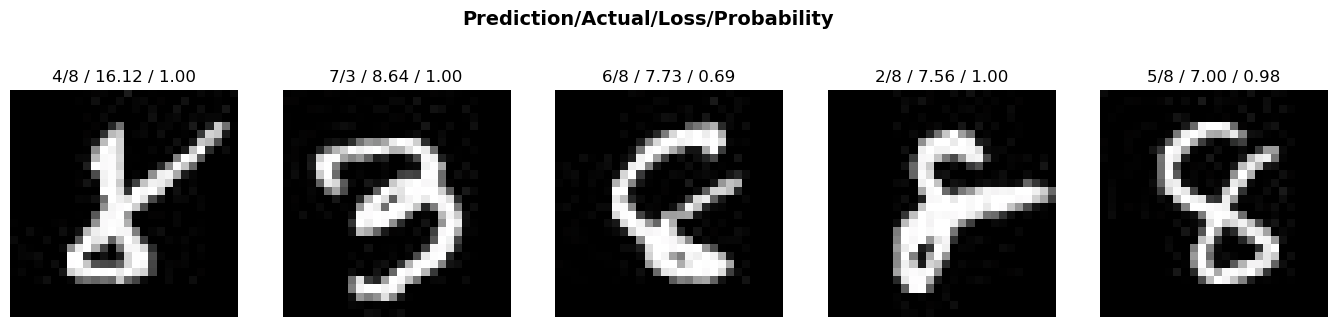

In [56]:
interp.plot_top_losses(5, nrows=1, figsize=(17,4))

We can correct images annotations or remove them, using the `ImageClassifierCleaner`. That will show the images for each class (in the train or validation set) where the trained model had the highest classification error. Let's import the required modules:

In [57]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

Each time we make a change in one class's and data set's (train/validation) samples, by reannotating/removing it, we need to run the following lines before changing to another class or data set, so the changes are applied to the actual data:

In [61]:
for ind in cleaner.delete(): cleaner.fns[ind].unlink()
for ind, cat in cleaner.change(): shutil.move(str(cleaner.fns[ind]), f"{train_dir}/{cat}")

In the end of validating the data, we need to create a new `DataLoaders` object, to reflect the changes made to the dataset, and retrain the model.

epoch,train_loss,valid_loss,error_rate,time
0,2.795555,1.342019,0.443914,00:06


epoch,train_loss,valid_loss,error_rate,time
0,1.438523,0.962120,0.300716,00:08
1,1.135789,0.664537,0.210024,00:08
2,0.830221,0.450894,0.133652,00:08
3,0.584083,0.362221,0.124105,00:08
4,0.418472,0.378130,0.121718,00:08
5,0.285779,0.320634,0.095465,00:08
6,0.194847,0.321378,0.093079,00:08
7,0.141932,0.309384,0.090692,00:08
8,0.099131,0.295548,0.088305,00:07
9,0.078589,0.292757,0.090692,00:08


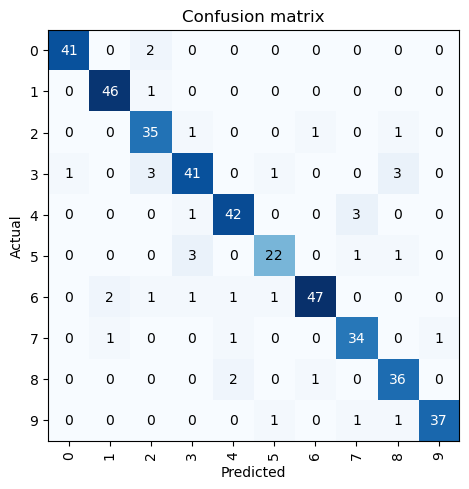

In [62]:
dls = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items = get_image_files,
                get_y = parent_label,
                splitter = RandomSplitter()
               ).dataloaders(train_dir)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [64]:
dls.n

1676

## Test Model

In [65]:
pd.read_csv("./data/mnist/sample_submission.csv").head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [66]:
test_dl = dls.test_dl(get_image_files(test_dir))
preds_probs = learn.get_preds(dl=test_dl)[0]  # probs

In [67]:
preds = preds_probs.max(axis=1).indices
ids = np.arange(1, preds.shape[0]+1)
submit_df = pd.DataFrame(np.vstack((ids, preds)).T, columns=["ImageId", "Label"])

In [68]:
submit_df.to_csv("./data/mnist/submission.csv", index=False)

We only used 5% of the data for training and validation, to make it faster, so, after iterating this process enough to be confident of our data processing and validation methods, and our model's architecture and hypeparameters, we would retrain and validate it on the whole dataset.

In [69]:
from shutil import rmtree

rmtree(train_dir)
rmtree(test_dir)

# Animals

- The Pan African Programme: The Cultured Chimpanzee, Wild Chimpanzee Foundation, DrivenData. (2022). Conser-vision Practice Area: Image Classification. Retrieved [Month Day Year] from https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/.

## Load Data

In [131]:
import pandas as pd

In [132]:
labels = pd.read_csv("./data/animals/train-labels.csv")

In [133]:
labels.head(2)

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [134]:
labels["label"] = labels.iloc[:, 1:].idxmax(axis=1).values
labels = labels[["id", "label"]].set_index("id")

In [135]:
display(labels.head(2))
print(labels.shape)

,label
id,
ZJ000000,bird
ZJ000001,monkey_prosimian


(16488, 1)


In [136]:
labels_sample = labels.groupby("label").sample(frac=0.05)["label"]

In [137]:
labels_sample

id
ZJ009857    antelope_duiker
ZJ006205    antelope_duiker
ZJ015289    antelope_duiker
ZJ002203    antelope_duiker
ZJ008486    antelope_duiker
                 ...       
ZJ012387             rodent
ZJ008316             rodent
ZJ012197             rodent
ZJ004787             rodent
ZJ007973             rodent
Name: label, Length: 826, dtype: object

## Train Model

In [138]:
from fastai.vision.all import *

In [139]:
train_path = "./data/animals/train/"
test_path = "./data/animals/test/"

In [140]:
def get_items(path):

    path = Path(path)
    res = []

    for filename in os.listdir(path):
        if filename[:-4] in labels_sample.index:
            res.append(path/filename)

    return L(res)

In [141]:
dls = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                get_items=get_items,
                get_y=lambda x: labels_sample.loc[x.name[:-4]], 
                splitter=RandomSplitter(),
                item_tfms=Resize(128, method="squish"),
                batch_tfms=[Normalize.from_stats(*imagenet_stats)]
               ).dataloaders(train_path)

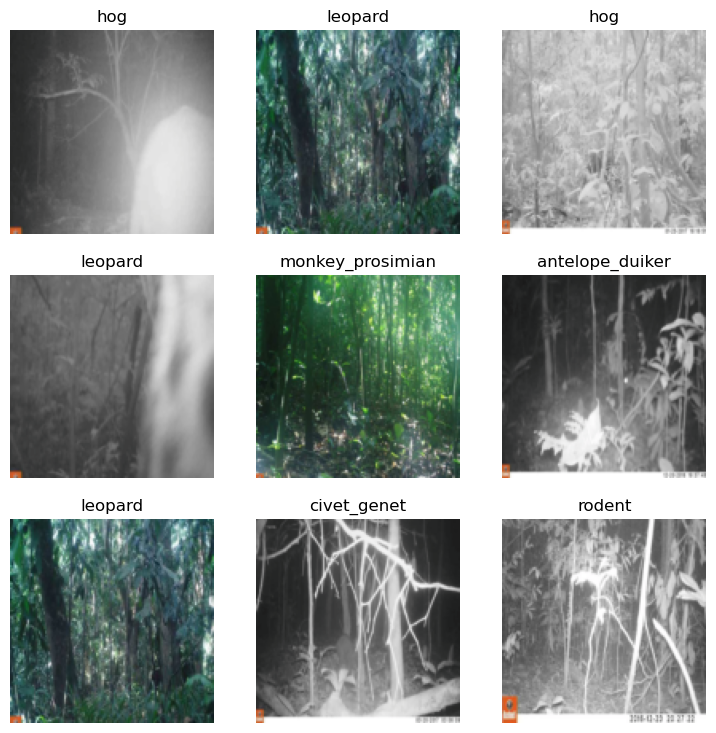

In [142]:
dls.show_batch()

In [143]:
dls.n

661

In [144]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,3.050437,2.190669,0.696970,00:10


epoch,train_loss,valid_loss,error_rate,time
0,1.883267,1.707361,0.551515,00:12
1,1.671480,1.513506,0.436364,00:12
2,1.359095,1.500973,0.460606,00:12
3,1.100571,1.569371,0.448485,00:11
4,0.877178,1.688496,0.460606,00:11
5,0.698931,1.693306,0.478788,00:11
6,0.563536,1.697963,0.430303,00:11
7,0.463716,1.748586,0.448485,00:11
8,0.376198,1.744868,0.448485,00:11
9,0.311529,1.747836,0.454545,00:11


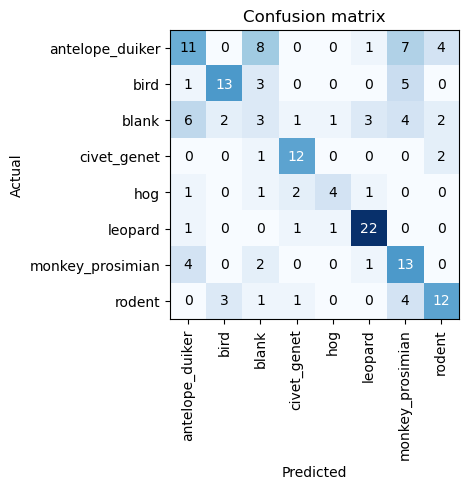

In [145]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

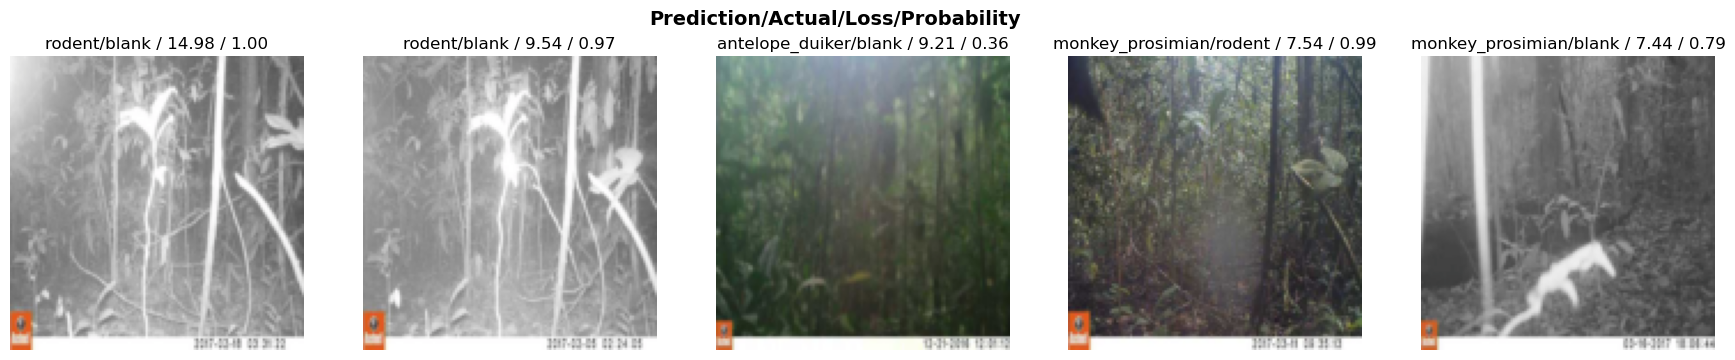

In [146]:
interp.plot_top_losses(k=5, nrows=1, figsize=(22,4))

In [147]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

I can't see enough to validate the images.

## Test Model

In [159]:
pd.read_csv("./data/animals/sample-submission.csv").head()

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ016488,0.048233,0.189185,0.044914,0.199588,0.106118,0.132915,0.166410,0.112637
1,ZJ016489,0.097078,0.061400,0.026409,0.241530,0.144344,0.051780,0.287811,0.089648
2,ZJ016490,0.124658,0.089101,0.189225,0.174494,0.180540,0.079995,0.085672,0.076314
3,ZJ016491,0.109966,0.048397,0.055598,0.323600,0.322356,0.063252,0.008160,0.068671
4,ZJ016492,0.165742,0.184610,0.005431,0.136806,0.000389,0.122078,0.151521,0.233423


In [149]:
test_dl = dls.test_dl(get_image_files(test_path))
preds_probs = learn.get_preds(dl=test_dl)[0]

In [150]:
ids = np.array([item.name[:-4] for item in test_dl.dataset.items])

In [151]:
learn.dls.vocab

['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']

In [163]:
submission_df = pd.DataFrame(data=preds_probs, columns= learn.dls.vocab)
submission_df.insert(0, "id", ids)
submission_df.sort_values(by="id", inplace=True)

In [164]:
submission_df.head()

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
1901,ZJ016488,0.003612,6.942989e-04,0.323665,5.332318e-01,0.020963,0.100759,1.180175e-02,0.005273
1693,ZJ016489,0.026071,8.592082e-02,0.024220,4.086171e-03,0.834774,0.011074,1.285491e-02,0.000999
2752,ZJ016490,0.030828,5.230120e-02,0.045449,1.384969e-01,0.718519,0.003206,7.886172e-03,0.003315
2542,ZJ016491,0.000002,8.615297e-08,0.000002,3.867934e-07,0.000002,0.999990,9.170705e-07,0.000002
2254,ZJ016492,0.500051,1.019086e-02,0.049266,3.648468e-02,0.045658,0.003554,3.501456e-01,0.004649


In [165]:
submission_df.to_csv("./data/animals/submission.csv", index=False)